In [1]:
from genre_classifier_cnn import build_model
import json
import numpy as np
from sklearn.model_selection import train_test_split
import librosa
import os
import math

2023-06-01 19:12:18.176841: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-01 19:12:20.046664: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
DATASET_PATH = "data_gender_voxceleb.json"

In [3]:
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)
    
    # convert lists into numpy array
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])

    return inputs, targets

def prepare_datasets(test_size, validation_size):
    # load data
    x, y = load_data(DATASET_PATH)

    # create train/test split
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=test_size, random_state=42, shuffle=True)

    # create train/validation split
    x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train,stratify=y_train, test_size=validation_size, random_state=42, shuffle=True)

    # 3d array (adds the "gray chanel" to the mfccs)
    x_train = x_train[..., np.newaxis] # 4d array -> (num_samples, 130, 13, 1)
    x_validation = x_validation[..., np.newaxis]
    x_test = x_test[..., np.newaxis]
    
    return x_train, x_validation, x_test, y_train, y_validation, y_test

def predict(model, x):

    classes = ['female', 'male']

    x = x[np.newaxis, ...]
    # prediction [[0.1, 0.2, ...]]
    prediction = model.predict(x) # x -> (1, 130, 13, 1)

    #extract idenx with max value
    predicted_index = np.argmax(prediction, axis=1) # [4]

    return predicted_index[0]

In [4]:
x_train, x_validation, x_test, y_train, y_validation, y_test = prepare_datasets(0.01, 0.01)
input_shape = (x_test.shape[1], x_test.shape[2], x_test.shape[3])

In [5]:
x_train.shape

(1084, 216, 13, 1)

In [12]:
model = build_model(input_shape)
model.load_weights('./checkpoints/gender_classifier_checkpoint').expect_partial()

### Compute metrics

In [13]:
y_pred = []
y_gt = []
for i in range(len(y_train)):
    x = x_train[i]
    y_gt.append(y_train[i])
    y_pred.append(predict(model, x))
    

1/1 [==============================] - 0s 37ms/step


In [20]:
#quantidadede 0s e 1s
print(y_pred.count(0))
print(y_pred.count(1))

580
504


In [21]:
print(y_gt.count(0))
print(y_gt.count(1))

434
650


In [22]:
set(y_pred)

{0, 1}

In [17]:
# calcular accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(f"Accuracy: {accuracy_score(y_gt, y_pred)}")
print(f"Precision: {precision_score(y_gt, y_pred)}")
print(f"Recall: {recall_score(y_gt, y_pred)}")
print(f"F1-score: {f1_score(y_gt, y_pred)}")

Accuracy: 0.7038745387453874
Precision: 0.8926014319809069
Recall: 0.5753846153846154
F1-score: 0.6997193638914874


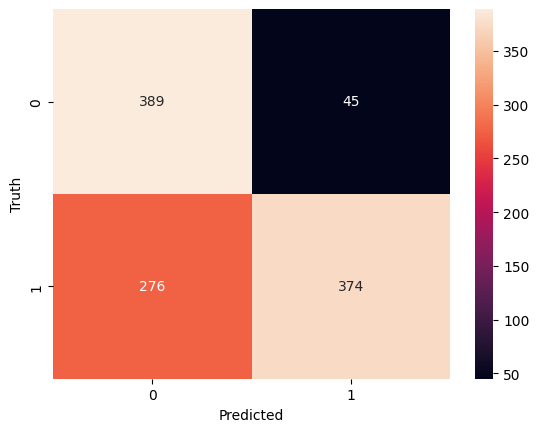

In [18]:
# calcular matriz de confusão
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_gt, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

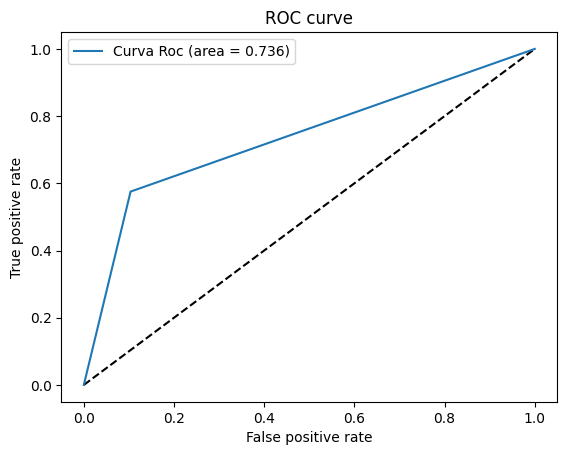

In [19]:
# calcular curva roc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_gt, y_pred)
auc_keras = roc_auc_score(y_gt, y_pred)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label=f'Curva Roc (area = {auc_keras:.3f})')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [14]:
def gen_input_mfcc_representation(audio_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5, track_duration=5):
    SAMPLE_RATE = 22050 # default
    TRACK_DURATION = track_duration # measured in seconds
    SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.

        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    signal, sample_rate = librosa.load(audio_path, sr=SAMPLE_RATE)

    for d in range(num_segments):

                # calculate start and finish sample for current segment
                start = samples_per_segment * d
                finish = start + samples_per_segment

                # extract mfcc
                mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                mfcc = mfcc.T
                print(len(mfcc))
                print(num_mfcc_vectors_per_segment)
                if len(mfcc) == num_mfcc_vectors_per_segment:
                    X = np.array([mfcc.tolist()]) ; X = X[..., np.newaxis]
                    return X
                else:     
                    return "Did not store because expects only mfcc feature with expected number of vectors"
    
    

In [15]:
from pydub import AudioSegment
def convert_ogg_to_mp3(m4a_file, mp3_file):
    audio = AudioSegment.from_file(m4a_file, format="ogg")
    audio.export(mp3_file, format="mp3")
 
convert_ogg_to_mp3("teste_de_macho_miguel.ogg","teste_de_macho_miguel.mp3")

FileNotFoundError: [Errno 2] No such file or directory: 'teste_de_macho_miguel.ogg'

In [ ]:
#display audio file
import IPython.display as ipd
ipd.Audio('voxceleb_5_sec/female/2205.mp3', rate=22050)

In [ ]:
X = gen_input_mfcc_representation('voxceleb_5_sec/female/126.mp3', num_segments=1, track_duration=5)

216
216


/home/yvson/Documents/IA/finalproject/gambs/voice-gender-classifier/venv/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
X.shape

(1, 216, 13, 1)

In [ ]:
resultado = predict(model, X)
print("Vc eh: ", resultado)

1/1 [==============================] - 0s 28ms/step
Vc eh:  male
